In [2]:
# std lib
from getpass import getpass
import warnings  
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning) # to quiet Astropy warnings

# 3rd party
import numpy as np
from numpy.core.defchararray import startswith
import pylab as plt
import matplotlib

from pyvo.dal import sia
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import make_lupton_rgb

# Data Lab
from dl import queryClient as qc, storeClient as sc, authClient as ac

In [3]:
# DECam images from Legacy Survey DR5
DEF_ACCESS_URL = "https://datalab.noirlab.edu/sia/ls_dr9"
svc_ls_dr9 = sia.SIAService(DEF_ACCESS_URL)

In [4]:
ra = 336.635 # in degrees
dec = -0.96 # in degrees

PIX_SCALE = 0.262
width = 2400 # in pixels
height = 1489 # in pixels
w = width * PIX_SCALE / 3600.0 # in degrees
h = height * PIX_SCALE / 3600.0 # in degrees

imgTable = svc_ls_dr9.search((ra,dec), (w, h), verbosity=2).to_table()

In [5]:
imgTable

assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
,,,bytes,,,,,,,,,,deg,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,arcsec,m,m,m,,d,d,s,s,,,,,,,,,,,,,,,,,
object,object,object,int32,object,object,int64,int64,int32,int32,object,object,object,object,object,object,object,object,object,object,str1,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
ls_dr9,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-3366m010-blobmodel-g.fits.fz&extn=1&POS=336.635,-0.96&SIZE=0.1746666666666667,0.10836611111111111",image/fits,50639,,,3,0,0,0,[],,,[0.26193],,ls_dr9,,DECaLS DR9,archival,,,DECam,g,,,ivo://datalab.noirlab/vo#ivoa_ls_dr9.siav1:ivo://datalab.noao/ls_dr9/legacysurvey-3366m010-blobmodel-g.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-3366m010-blobmodel-g.fits.fz&extn=1&POS=336.635,-0.96&SIZE=0.1746666666666667,0.10836611111111111&preview=true",,,336.625,-0.999997,--,,,--,3960.0,5480.0,--,--,--,--,--,--,,,,,0,DECaLS DR9,22.5,blobmodel,0,0,,0,,Stack,2013-09-05T01:53:51.912,,0
ls_dr9,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-3366m010-blobmodel-r.fits.fz&extn=1&POS=336.635,-0.96&SIZE=0.1746666666666667,0.10836611111111111",image/fits,50639,,,3,0,0,0,[],,,[0.26193],,ls_dr9,,DECaLS DR9,archival,,,DECam,r,,,ivo://datalab.noirlab/vo#ivoa_ls_dr9.siav1:ivo://datalab.noao/ls_dr9/legacysurvey-3366m010-blobmodel-r.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-3366m010-blobmodel-r.fits.fz&extn=1&POS=336.635,-0.96&SIZE=0.1746666666666667,0.10836611111111111&preview=true",,,336.625,-0.999997,--,,,--,5675.0,7155.0,--,--,--,--,--,--,,,,,0,DECaLS DR9,22.5,blobmodel,0,0,,0,,Stack,2013-09-29T03:49:30.303,,0
ls_dr9,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-3366m010-blobmodel-z.fits.fz&extn=1&POS=336.635,-0.96&SIZE=0.1746666666666667,0.10836611111111111",image/fits,50639,,,3,0,0,0,[],,,[0.26193],,ls_dr9,,DECaLS DR9,archival,,,DECam,z,,,ivo://datalab.noirlab/vo#ivoa_ls_dr9.siav1:ivo://datalab.noao/ls_dr9/legacysurvey-3366m010-blobmodel-z.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-3366m010-blobmodel-z.fits.fz&extn=1&POS=336.635,-0.96&SIZE=0.1746666666666667,0.10836611111111111&preview=true",,,336.625,-0.999997,--,,,--,8500.0,10020.0,--,--,--,--,--,--,,,,,0,DECaLS DR9,22.5,blobmodel,0,0,,0,,Stack,2013-09-13T04:06:52.805,,0
ls_dr9,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-3366m010-chi2-g.fits.fz&extn=1&POS=336.635,-0.96&SIZE=0.1746666666666667,0.10836611111111111",image/fits,12608,,,3,0,0,2,[3600 3600],,,[0.26193],,ls_dr9,,DECaLS DR9,archival,,,DECam,g DECam SDSS c0001 4720.0 1520.0,,,ivo://datalab.noirlab/vo#ivoa_ls_dr9.siav1:ivo://datalab.noao/ls_dr9/legacysurvey-3366m010-chi2-g.fits.fz,,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-3366m010-chi2-g.fits.fz&extn=1&POS=336.635,-0.96&SIZE=0.1746666666666667,0.10836611111111111&preview=true",,,336.625,-0.999997,--,,,--,0.0,0.0,--,--,--,--,--,--,,,,,0,DECaLS DR9,0,chi2,0,0,,0,,Stack,,,0
ls_dr9,"https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&si

In [31]:
sel = (imgTable['proctype'] == 'Stack') & (imgTable['prodtype'] == 'image') & \
    (startswith(imgTable['obs_bandpass'].astype(str),'i'))

In [32]:
row = imgTable[sel]
row

assoc_id,access_url,access_format,access_estsize,dataproduct_type,dataproduct_subtype,calib_level,dataset_length,im_nsubarrays,im_naxes,im_naxis,im_pixtype,im_wcsaxes,im_scale,obs_title,obs_id,obs_creator_name,obs_collection,obs_creation_type,obs_creation_date,facility_name,instrument_name,obs_bandpass,obs_datasource,proposal_id,obs_publisher_did,obs_release_date,preview,target_name,target_class,s_ra,s_dec,s_fov,s_region,s_calib_status,s_resolution,em_min,em_max,em_resolution,em_res_power,t_min,t_max,t_exptime,t_resolution,o_ucd,o_unit,pol_states,object,airmass,project_code,magzero,prodtype,seeing,fwhm,fileset_id,exptime,photflag,proctype,date_obs,mjd_obs,elliptic
,,,bytes,,,,,,,,,,deg,,,,,,,,,,,,,,,,,deg,deg,deg,deg,,arcsec,m,m,m,,d,d,s,s,,,,,,,,,,,,,,,,,
object,object,object,int32,object,object,int64,int64,int32,int32,object,object,object,object,object,object,object,object,object,object,str1,object,object,object,object,object,object,object,object,object,float64,float64,float64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object


In [8]:
row = imgTable[sel][0]
url = row['access_url']
url

'https://datalab.noirlab.edu/svc/cutout?col=ls_dr9&siaRef=legacysurvey-3366m010-image-r.fits.fz&extn=1&POS=336.635,-0.96&SIZE=0.1746666666666667,0.10836611111111111'

In [9]:
filename = download_file(url, cache=True, show_progress=True, timeout=120)
hdu = fits.open(filename)[0]
image = hdu.data
hr = hdu.header
wcs = WCS(hr)

In [44]:
sel = (imgTable['proctype'] == 'Stack') & (imgTable['prodtype'] == 'psfdepth')
rows = imgTable[sel]
url = rows[0]['access_url']
filename = download_file(url, cache=True, show_progress=True, timeout=120)
hdu = fits.open(filename)[0]

In [45]:
hdu.header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 2401 / length of data axis 1                          
NAXIS2  =                 1490 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
COMMENT Data product of the DESI Imaging Legacy Surveys                         
COMMENT Full documentation at http://legacysurvey.org                           
LEGPIPEV= 'DR9.6.5 '           / legacypipe git version                         
LSDIR   = '/global/cscratch1/sd/ziyaoz/dr9m/south' / $LEGACY_SURVEY_DIR director
LSDR    = 'DR9     '        

-0.013908511 35.622124 (1490, 2401)


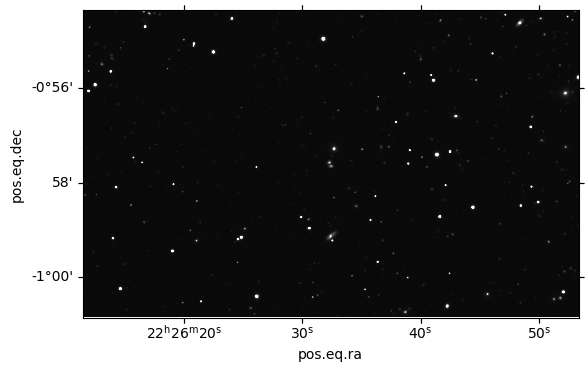

In [27]:
print(image.min(),image.max(),image.shape)
ax = plt.subplot(projection=wcs)
ax.imshow(image,cmap='gray',vmin=image.min(),vmax=image.min()+(image.max()-image.min())/100.)

In [96]:
sql = '''SELECT ra, dec
            FROM ls_dr9.tractor
            WHERE BRICKID = {0} AND (TYPE IN ('PSF'))
'''.format(hr['BRICKID'])
df = qc.query(sql=sql, fmt='pandas')

In [97]:
df

,ra,dec
0,336.510528,-1.124837
1,336.502770,-1.117152
2,336.500583,-1.114319
3,336.501233,-1.112929
4,336.502899,-1.115493
...,...,...
3576,336.748557,-0.908539
3577,336.748866,-0.906026
3578,336.747585,-0.899012
3579,336.749290,-0.897327


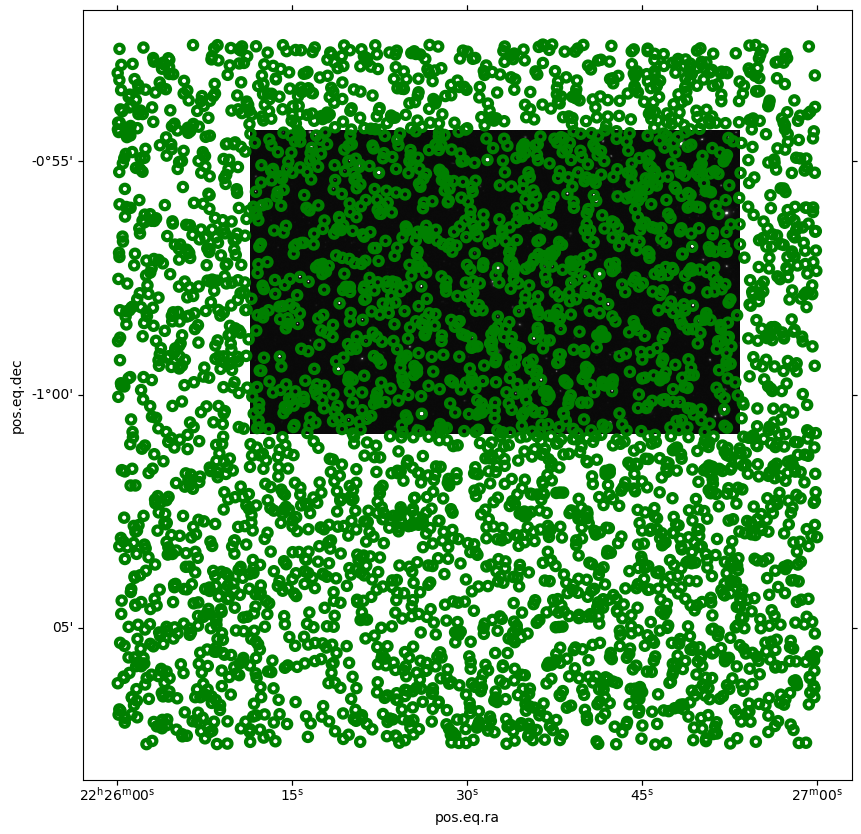

In [98]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1, projection=wcs)
ax.imshow(image, cmap='gray', vmin=image.min(), vmax=image.min()+(image.max()-image.min())/100.)
ax.scatter(df['ra'], df['dec'], transform=ax.get_transform('icrs'), 
           edgecolor='green', facecolor='none', linewidths=3)

In [ ]:
brick_min_ra = ra - w / 2
brick_max_ra = ra + w / 2
brick_min_dec = dec - h / 2
brick_max_dec = dec + h / 2
# convert to AAAcBBB format
min_ra_stripped = int(float(str(brick_min_ra).lstrip("0")))
max_ra_stripped = int(float(str(brick_max_ra).lstrip("0")))
min_dec_stripped = abs(int(float(str(brick_min_dec).lstrip("0"))))
max_dec_stripped = abs(int(float(str(brick_max_dec).lstrip("0"))))
min_ra = f"{min_ra_stripped:03d}".replace(".", "")
max_ra = f"{max_ra_stripped:03d}".replace(".", "")
min_dec = f"{min_dec_stripped:03d}".replace(".", "")
max_dec = f"{max_dec_stripped:03d}".replace(".", "")
min_dec_sign = "p" if brick_min_dec >= 0 else "m"
max_dec_sign = "p" if brick_min_dec >= 0 else "m"
sweep_filename = (
    f"sweep-{min_ra}{min_dec_sign}{min_dec}-{max_ra}{max_dec_sign}{max_dec}.fits"
)
print(sweep_filename)
filename = download_file(f"https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/sweep/9.0/{sweep_filename}",
                         cache=True, show_progress=True, timeout=120)
hdu = fits.open(filename)[1]
df = hdu.data
df

In [26]:
brick_id = hr['BRICKID']

survey_bricks_filename = download_file("https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/survey-bricks.fits.gz",
                                        cache=True, show_progress=True, timeout=120)
hdu = fits.open(survey_bricks_filename)[1]
df_bricks = hdu.data

print("Brick ID:", brick_id)
df_bricks

brick_name = df_bricks[df_bricks['BRICKID'] == brick_id]['BRICKNAME'][0]
ra_int = int(float(str(ra).lstrip("0")))
tractor_filename = download_file(f"https://portal.nersc.gov/cfs/cosmo/data/legacysurvey/dr9/south/tractor/{ra_int:03d}/tractor-{brick_name}.fits",
                                 cache=True, show_progress=True, timeout=120)
tractor = fits.open(tractor_filename)
tractor

325954


In [30]:
tractor[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
COMMENT Data product of the DESI Imaging Legacy Surveys                         
COMMENT Full documentation at http://legacysurvey.org                           
LEGPIPEV= 'DR9.6.5 '           / legacypipe git version                         
LSDIR   = '/global/cscratch1/sd/ziyaoz/dr9m/south' / $LEGACY_SURVEY_DIR director
LSDR    = 'DR9     '           / Data release number                            
RUNDATE = '2020-09-13T23:25:01.279042' / runbrick.py run time                   
SURVEY  = 'DECaLS+BASS+MzLS'

In [1]:
%env BLISS_HOME=/home/zhteoh/772-infer-decals

env: BLISS_HOME=/home/zhteoh/772-infer-decals
Obtaining file:///home/zhteoh/772-infer-decals
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for bliss-deblender (pyproject.toml) ... done
  Created wheel for bliss-deblender: filename=bliss_deblender-0.2.1-py3-none-any.whl size=4243 sha256=a9a78e8f4827b2068172bc3007c19c9385845b53dc6996b0adc77a270bd6a5ac
  Stored in directory: /tmp/pip-ephem-wheel-cache-edcd0oes/wheels/bf/49/24/26c84861b54a9803e2d2d3ea384f29c05fc36d791f173cba9c
Successfully built bliss-deblender
  Attempting uninstall: bliss-deblender
    Found existing installation: bliss-deblender 0.2.1
    Uninstalling bliss-deblender-0.2.1:
      Successfully uninstalled bliss-deblender-0.2.1
Note: you may need to restart the kernel to use updated packages.


In [3]:
from bliss.predict import predict_decals
from bliss.conf.igs import base_config

cfg = base_config()
cfg.predict.dataset["_target_"] = "bliss.surveys.decals.DarkEnergyCameraLegacySurvey"
cfg.predict.dataset.decals_dir = "${paths.decals}"
cfg.predict.dataset.ra = 336.635
cfg.predict.dataset.dec = -0.96
cfg.predict.dataset.width = 2400
cfg.predict.dataset.height = 1489
cfg.predict.dataset.bands = ["g"]
cfg.predict.plot.show_plot = False
predict_decals(cfg)


                 from  n    params  module                                  arguments                     
  0                -1  1      3328  yolov5.models.common.Conv               [2, 64, 5, 1]                 
  1                -1  3     12672  yolov5.models.common.Conv               [64, 64, 1, 1]                
  2                -1  1     73984  yolov5.models.common.Conv               [64, 128, 3, 2]               
  3                -1  1    147712  yolov5.models.common.Conv               [128, 128, 3, 1]              
  4                -1  1    295424  yolov5.models.common.Conv               [128, 256, 3, 2]              
  5                -1  6   1118208  yolov5.models.common.C3                 [256, 256, 6]                 
  6                -1  1   1180672  yolov5.models.common.Conv               [256, 512, 3, 2]              
  7                -1  9   6433792  yolov5.models.common.C3                 [512, 512, 9]                 
  8                -1  1   4720640  

Predicting: 0it [00:00, ?it/s]

({'star_log_fluxes': tensor([[[-163.02621],
          [-160.46223],
          [-157.83058],
          ...,
          [-159.44780],
          [-160.25375],
          [-159.66896]]]), 'star_fluxes': tensor([[[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]]), 'source_type': tensor([[[0],
          [0],
          [0],
          ...,
          [1],
          [1],
          [1]]]), 'galaxy_params': tensor([[[0.00000e+00, 4.43340e-06, 3.85792e-10,  ..., 1.42067e-15, 2.42810e-23, 1.61253e-09],
          [0.00000e+00, 1.52115e-04, 3.12541e-10,  ..., 1.41660e-15, 5.00283e-23, 2.25991e-09],
          [0.00000e+00, 2.92943e-04, 1.91927e-10,  ..., 1.47315e-15, 5.37869e-22, 2.93852e-09],
          ...,
          [0.00000e+00, 1.00000e+00, 7.09851e-11,  ..., 2.26746e-16, 1.97196e-32, 9.52199e-14],
          [0.00000e+00, 1.00000e+00, 8.01420e-11,  ..., 2.21636e-16, 1.59082e-32, 1.50163e-13],
          [0.00000e+00, 1.83457e-01, 1.97992e-10,  ..., 5